In [150]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 as cv
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score, accuracy_score
from pathlib import Path

# Function Used

In [2]:
# Image used : all of images in the folder "skin-90"
# Function Load images from dir

def load_img(img_dir):
    p = Path(img_dir)
    dirs = p.glob('*')
    
    img_list = []
    
    selected_dir_names = ['blackhead', 'Pustula', 'papula', 'whitehead']
    selected_dirs = [dir for dir in dirs if str(dir).split('/')[-1] in selected_dir_names]
    
    for dir in selected_dirs:
        label = str(dir).split('/')[-1]
        for file in dir.glob('*'):
            if file.suffix.lower() in ['.jpg', '.png', '.JPG', '.jfif']:
                img = mpimg.imread(str(file))
                
                if not img is None:
                    img_list.append((img, label))
    
    return img_list

In [83]:
# Function to visualize random images in a list

def random_vis_img(img_list):
    random = np.random.randint(0, len(img_list))
    
    img = img_list[random][0]
    label = img_list[random][1]

    if (len(img.shape) == 2):
        print(img.shape)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.show()
    else:
        print(img.shape)
        plt.imshow(img)
        plt.title(label)
        plt.show()
        

In [105]:
# Function menampilkan hasil histogram features lbp dari list

def random_vis_hist(feature_list):
    random = np.random.randint(0, len(feature_list))
    
    feature = feature_list[random]
    label = feature[1]
    
    plt.hist(feature[0])
    plt.title(label)
    plt.show()

In [12]:
# Function untuk melakukan resizing image

def resize_img(img_list, size):
    img_resized = []
    
    for img in img_list:
        img_resized.append((cv.resize(img[0], size), img[1]))
    
    return img_resized

In [76]:
# Function untuk melakukan grayscaling image

def grayscale_img(img_list):
    img_gray = []
    
    for img in img_list:
        img_gray.append((cv.cvtColor(img[0], cv.COLOR_RGB2GRAY), img[1]))
    
    return img_gray

In [103]:
# Function untuk melakukan ektraksi fitur dengan LBP

def extract_lbp_features(img_list, P=8, R=1):
    lbp_features = []
    
    for img in img_list:
        lbp = local_binary_pattern(img[0], P, R, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
        hist = hist.astype('float')
        hist /= (hist.sum() + 1e-6)
        lbp_features.append((hist, img[1]))
    
    return lbp_features

In [120]:
# Function untuk melakukan standarisasi

def standardize_features(features):
    scaler = StandardScaler()
    
    return scaler.fit_transform(features)

# Load Images

In [4]:
train_dir = './skin-90/Training'
test_dir = './skin-90/Test'

In [5]:
train_img_list = load_img(train_dir)
test_img_list = load_img(test_dir)

(1039, 1100, 3)


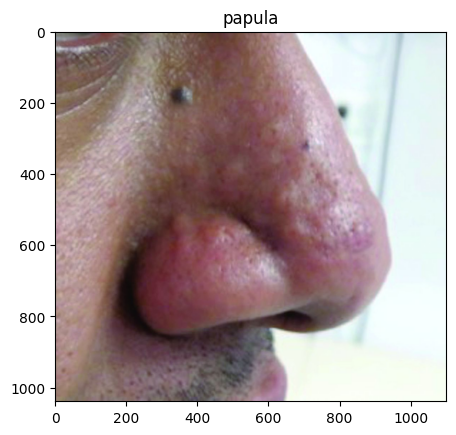

In [10]:
# Menampilkan image secara random dari dataset training

random_vis_img(train_img_list)

# Preprocess

In [62]:
# Melakukan resizing image training dan testing menjadi 200x200

train_img_resized = resize_img(train_img_list, (200, 200))
test_img_resized = resize_img(test_img_list, (200, 200))

(200, 200, 3)


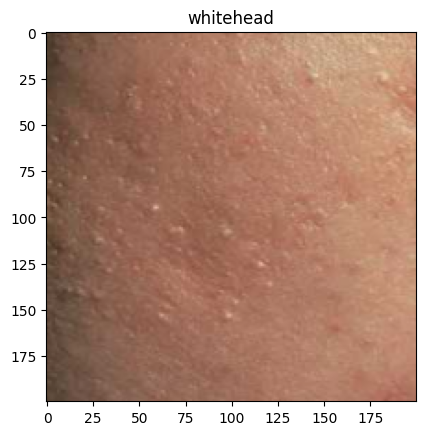

In [75]:
# Menampilkan hasil resized image

random_vis_img(train_img_resized)

In [77]:
# Melakukan grayscaling image terhadap dataset training dan testing

train_img_grayscaled = grayscale_img(train_img_resized)
test_img_grayscaled = grayscale_img(test_img_resized)

(200, 200)


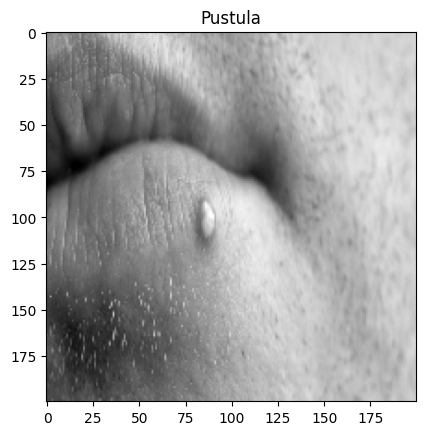

In [99]:
# Menampilkan hasil grayscaling image pada dataset training

random_vis_img(train_img_grayscaled)

# Extract Features

In [104]:
# Melakukan ektraksi fitur menggunakan LBP

train_img_features = extract_lbp_features(train_img_grayscaled)
test_img_features = extract_lbp_features(test_img_grayscaled)

/home/gin_arata/Documents/Kuliah/Semester 5/Machine Learning/uts/machine-learning-kuliah/lib/python3.12/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


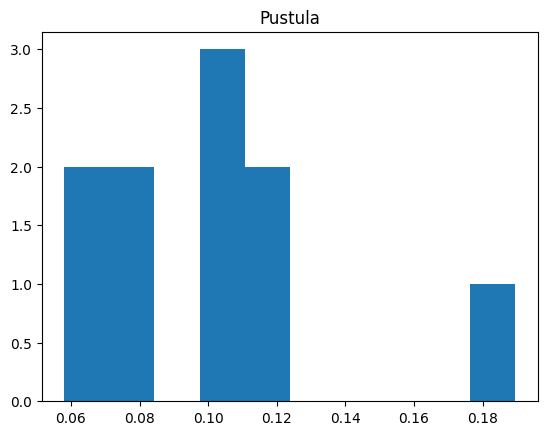

In [118]:
# Menampilkan hasil histogram hasil lbp pada dataset training

random_vis_hist(train_img_features)

## Standarisasi Features

In [122]:
# Melakukan pembagian feature dan target

X_train = np.array([feature[0] for feature in train_img_features])
y_train = np.array([feature[1] for feature in train_img_features])

X_test = np.array([feature[0] for feature in test_img_features])
y_test = np.array([feature[1] for feature in test_img_features])

In [123]:
# Melakukan standarisasi terhadap feature lbp

X_train_standardized = standardize_features(X_train)
X_test_standardized = standardize_features(X_test)

In [134]:
# Menampilkan hasil sebelum dilakukan standarisasi dan sudah

print('Before standardized')
print(X_train[1])
print('After standardized')
print(X_train_standardized[1])

Before standardized
[0.08745  0.10865  0.0619   0.0782   0.07835  0.073725 0.07525  0.10785
 0.13385  0.194775]
After standardized
[ 1.8261749   1.97560089  1.05975192 -1.70834507 -1.67685807 -1.84485358
 -1.3034337   1.886561    0.77361489  2.09830253]


# Training Models

## KMeans

In [146]:
# Melakukan training pada model KMeans dengan cluster 2

kmeans_2 = KMeans(n_clusters=2, random_state=42)
kmeans_2.fit(X_train_standardized)
train_cluster_2 = kmeans_2.predict(X_train_standardized)
test_cluster_2 = kmeans_2.predict(X_test_standardized)

In [153]:
# Menampilkan hasil evaluasi clustering dengan cluster 2

# Menghitung nilai silhouette score training
silhouette_score_2_train = silhouette_score(X_train_standardized, train_cluster_2)

ari_2_train = adjusted_rand_score(y_train, train_cluster_2)
homogeneity_2_train = homogeneity_score(y_train, train_cluster_2)
completeness_2_train = completeness_score(y_train, train_cluster_2)
v_measure_2_train = v_measure_score(y_train, train_cluster_2)

print('Training Evaluation')
print('Silhouette Score :', silhouette_score_2_train)
print('ARI :', ari_2_train)
print('Homogeneity :', homogeneity_2_train)
print('Completeness :', completeness_2_train)
print('V Measure :', v_measure_2_train)

# Menghitung nilai silhouette score testing
silhouette_score_2_test = silhouette_score(X_test_standardized, test_cluster_2)

ari_2_test = adjusted_rand_score(y_test, test_cluster_2)
homogeneity_2_test = homogeneity_score(y_test, test_cluster_2)
completeness_2_test = completeness_score(y_test, test_cluster_2)
v_measure_2_test = v_measure_score(y_test, test_cluster_2)

print('\nTesting Evaluation')
print('Silhouette Score :', silhouette_score_2_test)
print('ARI :', ari_2_test)
print('Homogeneity :', homogeneity_2_test)
print('Completeness :', completeness_2_test)
print('V Measure :', v_measure_2_test)

Training Evaluation
Silhouette Score : 0.43838028402902174
ARI : 0.03989935111858854
Homogeneity : 0.03674358328844364
Completeness : 0.07679052372244169
V Measure : 0.04970416517898397

Testing Evaluation
Silhouette Score : 0.3252318399560923
ARI : -0.02571595558153127
Homogeneity : 0.021222140123830387
Completeness : 0.04391005802958035
V Measure : 0.02861458482191513


## SVM

In [148]:
# Melakukan training SVM

svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_standardized, y_train)

SVC(kernel='linear', random_state=42)

In [149]:
# Melakukan prediksi terhadap training dan testing

y_pred_train = svm.predict(X_train_standardized)
y_pred_test = svm.predict(X_test_standardized)

In [152]:
# Menampilkan hasil evaluasi SVM

y_pred_train_score = accuracy_score(y_train, y_pred_train)
y_pred_test_score = accuracy_score(y_test, y_pred_test)

print('Training Accuracy :', y_pred_train_score)
print('Testing Accuracy :', y_pred_test_score)

Training Accuracy : 0.5976095617529881
Testing Accuracy : 0.5357142857142857
